# Importing Libraries

In [2]:
import os
import cv2
import glob
import shutil
import numpy as np
np.set_printoptions(precision=3, suppress=True)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import radiomics
import csv

import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt
#!pip install git+https://github.com/miykael/gif_your_nifti.git
import gif_your_nifti.core as gif2nif

import keras
import keras.backend as K
from keras.callbacks import CSVLogger
from keras.utils.np_utils import to_categorical   
from sklearn.metrics import log_loss
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard

C:\Users\Larkana Computers\anaconda3\envs\BraTS\lib\site-packages\nilearn\__init__.py:67: FutureWarning: Python 3.7 support is deprecated and will be removed in release 0.12 of Nilearn. Consider switching to Python 3.9 or 3.10.
  _python_deprecation_warnings()


In [3]:
# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

## Define Constants

In [4]:
# DEFINE seg-areas  
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', 
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3 later
}

# days start interval
SURVIVAL_CATEGORIES= {
    'SHORT' : 0 , # 0-300
    'MEDIUM' : 300,  # 300-450
    'LONG' : 450, # 450 and more
}

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5 
VOLUME_SLICES = 100 
VOLUME_START_AT = 22 # first slice of volume that we will include
IMG_SIZE = 128

In [5]:
#Read Dataset From USB
import os

# Define the path to your Jupyter Notebook directory
notebook_directory = r'C:\Users\Larkana Computers\BraTS20'

# Define the path to the dataset directory
dataset_directory = r'E:\BraTS20\MICCAI_BraTS2020_TrainingData'

# Use os.path.join to create the full path to the dataset from your notebook's location
TRAIN_DATASET_PATH = os.path.join(dataset_directory)

# You can now use full_dataset_path to access the dataset in your Jupyter Notebook.
print("Path: ", TRAIN_DATASET_PATH)
from os.path import exists
file = exists(TRAIN_DATASET_PATH)
print("Path Exists: ",file)

Path:  E:\BraTS20\MICCAI_BraTS2020_TrainingData
Path Exists:  True


In [6]:
# lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]
# file BraTS20_Training_355 has ill formatted name for for seg.nii file
train_and_val_directories.remove(TRAIN_DATASET_PATH+'\BraTS20_Training_355')

def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories); 

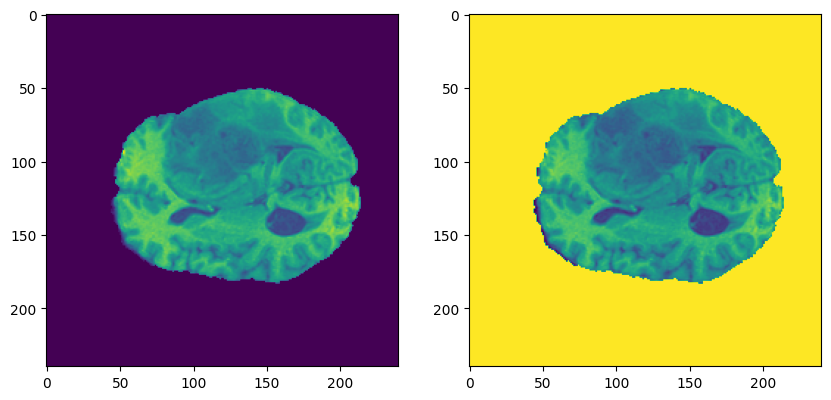

In [7]:
my_loc_slice=73
image_volume=nib.load(TRAIN_DATASET_PATH+'/BraTS20_Training_001/BraTS20_Training_001_t1.nii').get_fdata()
my_img=image_volume[:,:,my_loc_slice]
my_converted_img = my_img.copy()
my_converted_img[my_converted_img == 0] = 666


f, axarr = plt.subplots(1,2, figsize = (10, 5))
axarr[0].imshow(my_img)
axarr[1].imshow(my_converted_img)

### Count number of pixels for each segment for each slice in volume

count class 1: 287
{1: 287, 2: 3843, 3: 631}


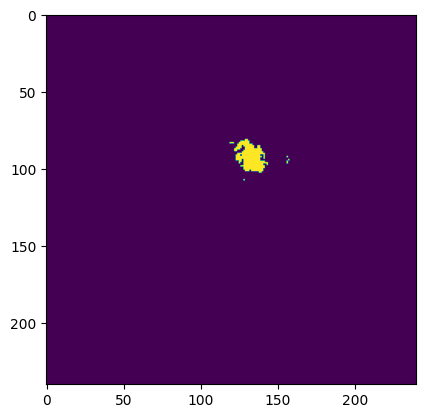

In [8]:
def maskSizeForSlice(path,i_slice):
    totals = dict([(1, 0), (2, 0), (3, 0)])
    image_volume=nib.load(path).get_fdata()
    # flatten 3D image into 1D array and convert mask 4 to 2
    arr=image_volume[:,:,i_slice].flatten()
    arr[arr == 4] = 3

    unique, counts = np.unique(arr, return_counts=True)
    unique = unique.astype(int)
    values_dict=dict(zip(unique, counts))
    for k in range(1,4):
        totals[k] += values_dict.get(k,0)
    return totals

my_loc_slice=73
my_loc_class=1
seg_sum=maskSizeForSlice(TRAIN_DATASET_PATH+'/BraTS20_Training_001/BraTS20_Training_001_seg.nii',my_loc_slice)

image_volume=nib.load(TRAIN_DATASET_PATH+'/BraTS20_Training_001/BraTS20_Training_001_seg.nii').get_fdata()
image_loc=image_volume[:,:,my_loc_slice]
image_loc[image_loc != my_loc_class] = 0

# plot segment only for class 'my_loc_class'
plt.imshow(image_loc)

image_loc=image_loc.flatten()
count = np.count_nonzero(image_loc == my_loc_class)
print(f'count class {my_loc_class}: {count}')
print(seg_sum)

# Survival Prediction

#### Check the age distrubution in our dataset and their survival days

In [9]:
#csv_path = 'BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/survival_info.csv'
csv_path = TRAIN_DATASET_PATH+'\\survival_info.csv'

age_dict = {}
days_dict = {}


with open(csv_path, mode='r') as csv_file:
    csv_reader = csv.reader(csv_file,delimiter = ',')
  #  row_count = sum(1 for row in csv_reader)
 #   print(f'total rows: {row_count} .')
    at_line = 0
    category_short = 0
    category_medium = 0
    category_long = 0
    max_days = 0
    for row in csv_reader:
        if at_line == 0:
            print(f'Column names are {", ".join(row)}')
            at_line += 1
        else:
            if (row[3] != "GTR"):
                continue
            print(row)
            key = row[0]
            age = row[1]
            days = row[2]
            if (not days.isnumeric()):
                continue
            age_dict[key] = float(age)
            days_dict[key] = int(days)
            max_days = max(max_days,int(days))
            if int(days) < 250:
                category_short += 1
            elif (int(days) >= 250 and int(days) <= 450):
                category_medium += 1
            else:
                category_long += 1
            at_line+=1

    print(f'Processed {at_line} lines.')
    print(category_short,category_medium,category_long)
    print(max_days)

Column names are Brats20ID, Age, Survival_days, Extent_of_Resection
['BraTS20_Training_001', '60.463', '289', 'GTR']
['BraTS20_Training_002', '52.263', '616', 'GTR']
['BraTS20_Training_003', '54.301', '464', 'GTR']
['BraTS20_Training_004', '39.068', '788', 'GTR']
['BraTS20_Training_005', '68.493', '465', 'GTR']
['BraTS20_Training_006', '67.126', '269', 'GTR']
['BraTS20_Training_007', '69.912', '503', 'GTR']
['BraTS20_Training_009', '56.419', '1155', 'GTR']
['BraTS20_Training_010', '48.367', '515', 'GTR']
['BraTS20_Training_012', '65.899', '495', 'GTR']
['BraTS20_Training_013', '59.693', '698', 'GTR']
['BraTS20_Training_014', '51.734', '359', 'GTR']
['BraTS20_Training_015', '62.614', '169', 'GTR']
['BraTS20_Training_016', '55.759', '368', 'GTR']
['BraTS20_Training_017', '58.258', '439', 'GTR']
['BraTS20_Training_018', '61.605', '486', 'GTR']
['BraTS20_Training_019', '68.049', '287', 'GTR']
['BraTS20_Training_021', '56.921', '576', 'GTR']
['BraTS20_Training_022', '44.162', '350', 'GTR']


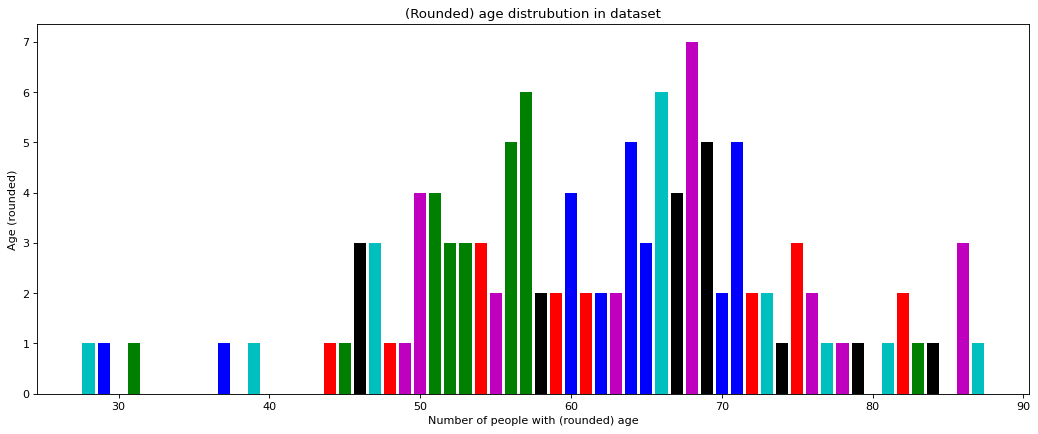

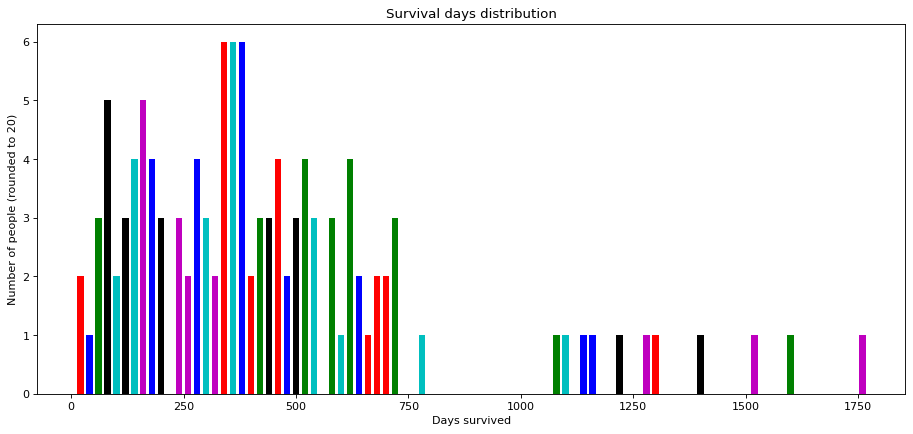

In [10]:
from collections import Counter
from itertools import cycle
#age_dict, days_dict 

# round values in dictionary
age_dict_rounded = {key : round(age_dict[key], 0) for key in age_dict}
# survival days are very distinct values => move the values in ranges per 20
days_dict_rounded = {key : round(days_dict[key]/20)*20 for key in days_dict}

# count same numbers => create statistics how many times is there person with same age
age_dict_rounded_counted = Counter(age_dict_rounded.values())
days_dict_rounded_counted = Counter(days_dict_rounded.values())

cycol = cycle('bgrcmk')
colors = list()
for i in range(len(age_dict_rounded_counted)):
    colors.append(next(cycol))
    
cycol = cycle('bgrcmk')    
colorsDays = list()
for i in range(len(days_dict_rounded_counted)):
    colorsDays.append(next(cycol))

plt.figure(figsize=(16, 6), dpi=80)
plt.xlabel('Number of people with (rounded) age')
plt.ylabel('Age (rounded)')
plt.title("(Rounded) age distrubution in dataset")
plt.bar(list(age_dict_rounded_counted.keys()), age_dict_rounded_counted.values(), color=colors)
plt.show()

plt.figure(figsize=(14, 6), dpi=80)
plt.xlabel('Days survived')
plt.ylabel('Number of people (rounded to 20)')
plt.title("Survival days distribution")
plt.bar(list(days_dict_rounded_counted.keys()), days_dict_rounded_counted.values(),width=15, color=colorsDays)
plt.show()

# Computing Segment Sizes

Find number of pixels for each class in volume, no need to compute as ration to image size, since all images are of same size 240x240

In [11]:
# get number of pixels for each segment as dictionary
# original images contain segment values (0,1,2,4) => 4 is our 3 ... :)
def getMaskSizesForVolume(image_volume):
    totals = dict([(1, 0), (2, 0), (3, 0)])
    for i in range(VOLUME_SLICES):
        # flatten 2D image into 1D array and convert mask 4 to 2
        arr=image_volume[:,:,i+VOLUME_START_AT].flatten()
        arr[arr == 4] = 3
        
        unique, counts = np.unique(arr, return_counts=True)
        unique = unique.astype(int)
        values_dict=dict(zip(unique, counts))
        for k in range(1,4):
            totals[k] += values_dict.get(k,0)
    return totals

total count: 1264556


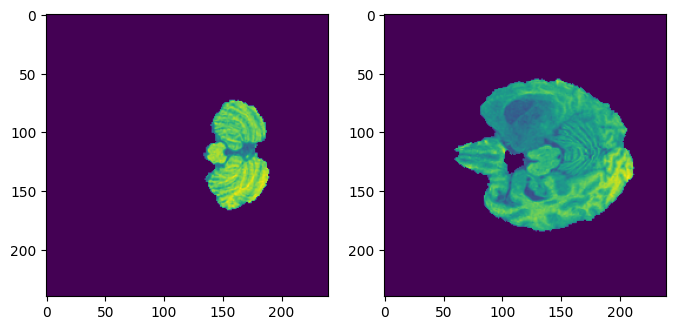

In [12]:
# returns count of non zero elements in whole 3D volume
def getBrainSizeForVolume(image_volume):
    total = 0
    for i in range(VOLUME_SLICES):
        arr=image_volume[:,:,i+VOLUME_START_AT].flatten()
        image_count=np.count_nonzero(arr)
        total=total+image_count
    return total

example_volume=nib.load(TRAIN_DATASET_PATH+'/BraTS20_Training_001/BraTS20_Training_001_t1.nii').get_fdata()

f, axarr = plt.subplots(1,2, figsize = (8, 4))
axarr[0].imshow(example_volume[:,:,VOLUME_START_AT])
axarr[1].imshow(example_volume[:,:,VOLUME_START_AT+30])

print(f'total count: {getBrainSizeForVolume(example_volume)}')

In [13]:
df2 = pd.read_csv(TRAIN_DATASET_PATH+'\\survival_info.csv')
targets = dict(df2.Brats20ID)
df2.head(10)

,Brats20ID,Age,Survival_days,Extent_of_Resection
0,BraTS20_Training_001,60.463,289,GTR
1,BraTS20_Training_002,52.263,616,GTR
2,BraTS20_Training_003,54.301,464,GTR
3,BraTS20_Training_004,39.068,788,GTR
4,BraTS20_Training_005,68.493,465,GTR
5,BraTS20_Training_006,67.126,269,GTR
6,BraTS20_Training_007,69.912,503,GTR
7,BraTS20_Training_008,68.285,1278,NaN
8,BraTS20_Training_009,56.419,1155,GTR
9,BraTS20_Training_010,48.367,515,GTR


In [14]:
targets

{0: 'BraTS20_Training_001',
 1: 'BraTS20_Training_002',
 2: 'BraTS20_Training_003',
 3: 'BraTS20_Training_004',
 4: 'BraTS20_Training_005',
 5: 'BraTS20_Training_006',
 6: 'BraTS20_Training_007',
 7: 'BraTS20_Training_008',
 8: 'BraTS20_Training_009',
 9: 'BraTS20_Training_010',
 10: 'BraTS20_Training_011',
 11: 'BraTS20_Training_012',
 12: 'BraTS20_Training_013',
 13: 'BraTS20_Training_014',
 14: 'BraTS20_Training_015',
 15: 'BraTS20_Training_016',
 16: 'BraTS20_Training_017',
 17: 'BraTS20_Training_018',
 18: 'BraTS20_Training_019',
 19: 'BraTS20_Training_020',
 20: 'BraTS20_Training_021',
 21: 'BraTS20_Training_022',
 22: 'BraTS20_Training_023',
 23: 'BraTS20_Training_024',
 24: 'BraTS20_Training_025',
 25: 'BraTS20_Training_026',
 26: 'BraTS20_Training_027',
 27: 'BraTS20_Training_028',
 28: 'BraTS20_Training_029',
 29: 'BraTS20_Training_030',
 30: 'BraTS20_Training_031',
 31: 'BraTS20_Training_032',
 32: 'BraTS20_Training_033',
 33: 'BraTS20_Training_034',
 34: 'BraTS20_Training_0

In [15]:
import nibabel as nib
import os
import albumentations as A
import numpy as np


class ImageReader:
    def __init__(self, img_size:int=256, normalize:bool=False, single_class:bool=False):
        pad_size = 256 if img_size > 256 else 224
        self.resize = A.Compose(
            [
                A.PadIfNeeded(min_height=pad_size, min_width=pad_size, value=0),
                A.Resize(img_size, img_size)
            ]
        )
        self.normalize=normalize
        self.single_class=single_class
        
    def read_file(self, path:str) -> dict:
        scan_type = path.split('_')[-1]
        raw_image = nib.load(path).get_fdata()
        raw_mask = nib.load(path.replace(scan_type, 'seg.nii')).get_fdata()
        processed_frames, processed_masks = [], []
        for frame_idx in range(raw_image.shape[2]):
            frame = raw_image[:, :, frame_idx]
            mask = raw_mask[:, :, frame_idx]
            if self.normalize:
                if frame.max() > 0:
                    frame = frame/frame.max()
                frame = frame.astype(np.float32)
            else:
                frame = frame.astype(np.uint8)
            resized = self.resize(image=frame, mask=mask)
            processed_frames.append(resized['image'])
            processed_masks.append(1*(resized['mask'] > 0) if self.single_class else resized['mask'])
        return {
            'scan': np.stack(processed_frames, 0),
            'segmentation': np.stack(processed_masks, 0),
            'orig_shape': raw_image.shape
        }
    
    def load_patient_scan(self, idx:int, patient_target_subdirectory:str, scan_type:str='flair') -> dict:
        patient_id = str(idx).zfill(3)
        patient_target_subdirectory_id = patient_target_subdirectory.split("_")[2]
        #print("patient_target_subdirectory_id", patient_target_subdirectory_id)
        #print("patient_id", patient_id)
        #scan_filename = f'BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{patient_id}/BraTS20_Training_{patient_id}_{scan_type}.nii'
        scan_filename = TRAIN_DATASET_PATH + f'\\BraTS20_Training_{patient_target_subdirectory_id}/BraTS20_Training_{patient_target_subdirectory_id}_{scan_type}.nii'
        #print(scan_filename)
        return self.read_file(scan_filename)
            

In [16]:
from os.path import exists
#file_exists = exists("/ input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS2020_Training_000/BraTS2020_Training_000_flair.nii")
#file_exists = exists("BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_flair.nii")
file_exists = exists(TRAIN_DATASET_PATH+"\\BraTS20_Training_001/BraTS20_Training_001_flair.nii")
print(file_exists)

True


In [17]:
import SimpleITK as sitk
from radiomics import base, cShape, deprecated
from radiomics import getProgressReporter
reader = ImageReader(img_size=128, normalize=True, single_class=False)

features = []
final_targets = []
#print(targets)
for patient_idx in targets:
        #print(patient_idx, targets[patient_idx])
    try:
        data = reader.load_patient_scan(patient_idx, targets[patient_idx])
        shape = radiomics.shape.RadiomicsShape(
            sitk.GetImageFromArray(data["scan"]), 
            sitk.GetImageFromArray(data["segmentation"])
        )
        #print(shape)
        try:
            patient_features = [
                shape.getMeshVolumeFeatureValue(),
                shape.getVoxelVolumeFeatureValue(),
                shape.getSurfaceAreaFeatureValue(),
                shape.getSurfaceVolumeRatioFeatureValue(),
                shape.getSphericityFeatureValue(),
                shape.getCompactness1FeatureValue(),
                shape.getCompactness2FeatureValue(),
                shape.getSphericalDisproportionFeatureValue(),
                shape.getMaximum3DDiameterFeatureValue(),
                shape.getMaximum2DDiameterSliceFeatureValue(),
                shape.getMaximum2DDiameterColumnFeatureValue(),
                shape.getMaximum2DDiameterRowFeatureValue(),
                shape.getMajorAxisLengthFeatureValue(),
                shape.getMinorAxisLengthFeatureValue(),
                shape.getLeastAxisLengthFeatureValue(),
                shape.getElongationFeatureValue(),
                shape.getFlatnessFeatureValue()
            ]
            features.append(patient_features)
            final_targets.append(targets[patient_idx])
        except Exception as e:
            print('Error with patient number {} - level 1: {}'.format(patient_idx, str(e)))
    except FileNotFoundError:
        print('Error with patient number {} - level 2: File Not Found'.format(patient_idx))


C:\Users\Larkana Computers\anaconda3\envs\BraTS\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Larkana Computers\anaconda3\envs\BraTS\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Error with patient number 98 - level 1: float division by zero
Error with patient number 225 - level 2: File Not Found


In [18]:
df_radiomics = pd.DataFrame(
    features,
    columns=[
        "getMeshVolumeFeatureValue", \
        "getVoxelVolumeFeatureValue", \
        "getSurfaceAreaFeatureValue", \
        "getSurfaceVolumeRatioFeatureValue", \
        "getSphericityFeatureValue", \
        "getCompactness1FeatureValue", \
        "getCompactness2FeatureValue", \
        "getSphericalDisproportionFeatureValue", \
        "getMaximum3DDiameterFeatureValue", \
        "getMaximum2DDiameterSliceFeatureValue", \
        "getMaximum2DDiameterColumnFeatureValue", \
        "getMaximum2DDiameterRowFeatureValue", \
        "getMajorAxisLengthFeatureValue", \
        "getMinorAxisLengthFeatureValue", \
        "getLeastAxisLengthFeatureValue", \
        "getElongationFeatureValue",
        "getFlatnessFeatureValue"
    ]
)
df_radiomics["target"] = final_targets
df_radiomics = df_radiomics.fillna(0)
df_radiomics.head(5)

,getMeshVolumeFeatureValue,getVoxelVolumeFeatureValue,getSurfaceAreaFeatureValue,getSurfaceVolumeRatioFeatureValue,getSphericityFeatureValue,getCompactness1FeatureValue,getCompactness2FeatureValue,getSphericalDisproportionFeatureValue,getMaximum3DDiameterFeatureValue,getMaximum2DDiameterSliceFeatureValue,getMaximum2DDiameterColumnFeatureValue,getMaximum2DDiameterRowFeatureValue,getMajorAxisLengthFeatureValue,getMinorAxisLengthFeatureValue,getLeastAxisLengthFeatureValue,getElongationFeatureValue,getFlatnessFeatureValue,target
0,4347.916667,4420.0,3635.999273,0.836262,0.354308,0.011188,0.044478,2.822402,43.737855,26.476405,40.224371,31.906112,35.580029,22.545023,14.054731,0.633643,0.395017,BraTS20_Training_001
1,2552.375000,2625.0,1281.055967,0.501907,0.705038,0.031406,0.350459,1.418364,34.190642,16.763055,34.132096,34.014703,27.538328,14.051830,9.631945,0.510264,0.349765,BraTS20_Training_002
2,144.583333,204.0,345.975286,2.392913,0.385051,0.012676,0.057089,2.597061,16.370706,9.486833,15.132746,16.278821,15.426859,7.137345,6.109090,0.462657,0.396003,BraTS20_Training_003
3,2789.625000,3033.0,3705.608957,1.328354,0.258616,0.006977,0.017297,3.866739,43.749286,23.409400,43.737855,41.436699,36.059592,19.398139,11.336193,0.537947,0.314374,BraTS20_Training_004
4,274.833333,1012.0,1903.057314,6.924405,0.107418,0.001868,0.001239,9.309395,46.368092,24.596748,31.144823,43.046487,46.271677,16.240151,11.152538,0.350974,0.241023,BraTS20_Training_005


In [19]:
from __future__ import print_function

import collections
from itertools import chain
import json
import logging
import os
import pathlib

import pykwalify.core
import SimpleITK as sitk
import six

from radiomics import generalinfo, getFeatureClasses, getImageTypes, getParameterValidationFiles, imageoperations


We have radiomics data for 234 patients, but we only have survival data for 119 patients, so we can analyze up to 119 (117 in the end)

In [20]:
radiomics_values = df_radiomics.loc[df_radiomics['target'] == "BraTS20_Training_001"]
display(radiomics_values)
radiomics_values.values.tolist()[0][:-1]
lol = []
lol.extend(radiomics_values.values.tolist()[0][:-1])

,getMeshVolumeFeatureValue,getVoxelVolumeFeatureValue,getSurfaceAreaFeatureValue,getSurfaceVolumeRatioFeatureValue,getSphericityFeatureValue,getCompactness1FeatureValue,getCompactness2FeatureValue,getSphericalDisproportionFeatureValue,getMaximum3DDiameterFeatureValue,getMaximum2DDiameterSliceFeatureValue,getMaximum2DDiameterColumnFeatureValue,getMaximum2DDiameterRowFeatureValue,getMajorAxisLengthFeatureValue,getMinorAxisLengthFeatureValue,getLeastAxisLengthFeatureValue,getElongationFeatureValue,getFlatnessFeatureValue,target
0,4347.916667,4420.0,3635.999273,0.836262,0.354308,0.011188,0.044478,2.822402,43.737855,26.476405,40.224371,31.906112,35.580029,22.545023,14.054731,0.633643,0.395017,BraTS20_Training_001


In [21]:
# Create a list of strings in the specified format
#brats_ids = [f'BraTS20_Training_{str(i).zfill(3)}' for i in range(1, 357)]

brats_ids = []
for i in targets:
    brats_ids.append(targets[i])
brats_ids

['BraTS20_Training_001',
 'BraTS20_Training_002',
 'BraTS20_Training_003',
 'BraTS20_Training_004',
 'BraTS20_Training_005',
 'BraTS20_Training_006',
 'BraTS20_Training_007',
 'BraTS20_Training_008',
 'BraTS20_Training_009',
 'BraTS20_Training_010',
 'BraTS20_Training_011',
 'BraTS20_Training_012',
 'BraTS20_Training_013',
 'BraTS20_Training_014',
 'BraTS20_Training_015',
 'BraTS20_Training_016',
 'BraTS20_Training_017',
 'BraTS20_Training_018',
 'BraTS20_Training_019',
 'BraTS20_Training_020',
 'BraTS20_Training_021',
 'BraTS20_Training_022',
 'BraTS20_Training_023',
 'BraTS20_Training_024',
 'BraTS20_Training_025',
 'BraTS20_Training_026',
 'BraTS20_Training_027',
 'BraTS20_Training_028',
 'BraTS20_Training_029',
 'BraTS20_Training_030',
 'BraTS20_Training_031',
 'BraTS20_Training_032',
 'BraTS20_Training_033',
 'BraTS20_Training_034',
 'BraTS20_Training_035',
 'BraTS20_Training_036',
 'BraTS20_Training_037',
 'BraTS20_Training_038',
 'BraTS20_Training_039',
 'BraTS20_Training_040',


In [22]:
# create only age: category data

# id: age, categories
def getListAgeDays(id_list):
    x_val = []  # Initialize an empty list to store feature data
    y_val = []  # Initialize an empty list to store category labels
    for i in id_list:
        if (i not in age_dict):  # Check if 'i' exists in the 'age_dict' dictionary
            continue
        masks = getMaskSizesForVolume(nib.load(TRAIN_DATASET_PATH + f'\\BraTS20_Training_{i[-3:]}/BraTS20_Training_{i[-3:]}_seg.nii').get_fdata())
        # Load a segmentation mask and extract its size information
        brain_vol = getBrainSizeForVolume(nib.load(TRAIN_DATASET_PATH + f'\\BraTS20_Training_{i[-3:]}/BraTS20_Training_{i[-3:]}_t1.nii').get_fdata())
        # Load a brain volume image and extract its size information
        masks[1] = masks[1]/brain_vol  # Normalize the size of the mask
        masks[2] = masks[2]/brain_vol
        masks[3] = masks[3]/brain_vol
        merged = [age_dict[i], masks[1], masks[2], masks[3]]
        # Create a feature vector by combining 'age_dict[i]' with mask size values
        radiomics_values = df_radiomics.loc[df_radiomics['target'] == str(i)]
        # Query a DataFrame 'df_radiomics' for radiomics values associated with 'i'
        if radiomics_values.empty:
            continue  # Skip this iteration if there are no radiomics values
        merged.extend(radiomics_values.values.tolist()[0][:-1])
        # Add radiomics values to the feature vector 'merged' excluding the last value
        x_val.append(merged)  # Append the feature vector to 'x_val'
        if (days_dict[i] < 250):
            y_val.append([1, 0, 0])  # Append category labels based on 'days_dict' conditions
        elif (days_dict[i] >= 250 and days_dict[i] < 450):
            y_val.append([0, 1, 0])
        else:
            y_val.append([0, 0, 1])
    return np.array(x_val), np.array(y_val)  # Return feature data and category labels as NumPy arrays

X_all, y_all = getListAgeDays(brats_ids)  # Call the function with 'train_and_test_ids'
print(f'X_test: {X_all.shape}')  # Print the shape of the feature data

X_test: (117, 21)


In [23]:
#df = pd.DataFrame(np.concatenate((X_all, y_all), axis=1) , columns = ["age",f"{SEGMENT_CLASSES[1]}",f"{SEGMENT_CLASSES[2]}",f"{SEGMENT_CLASSES[3]}","short","medium","long"])
df = pd.DataFrame(np.concatenate((X_all, y_all), axis=1) , columns = [
    "age",f"{SEGMENT_CLASSES[1]}",f"{SEGMENT_CLASSES[2]}",f"{SEGMENT_CLASSES[3]}", \
    "getMeshVolumeFeatureValue", \
    "getVoxelVolumeFeatureValue", \
    "getSurfaceAreaFeatureValue", \
    "getSurfaceVolumeRatioFeatureValue", \
    "getSphericityFeatureValue", \
    "getCompactness1FeatureValue", \
    "getCompactness2FeatureValue", \
    "getSphericalDisproportionFeatureValue", \
    "getMaximum3DDiameterFeatureValue", \
    "getMaximum2DDiameterSliceFeatureValue", \
    "getMaximum2DDiameterColumnFeatureValue", \
    "getMaximum2DDiameterRowFeatureValue", \
    "getMajorAxisLengthFeatureValue", \
    "getMinorAxisLengthFeatureValue", \
    "getLeastAxisLengthFeatureValue", \
    "getElongationFeatureValue", \
    "getFlatnessFeatureValue", \
    "short","medium","long"])
df.head()

,age,NECROTIC/CORE,EDEMA,ENHANCING,getMeshVolumeFeatureValue,getVoxelVolumeFeatureValue,getSurfaceAreaFeatureValue,getSurfaceVolumeRatioFeatureValue,getSphericityFeatureValue,getCompactness1FeatureValue,...,getMaximum2DDiameterColumnFeatureValue,getMaximum2DDiameterRowFeatureValue,getMajorAxisLengthFeatureValue,getMinorAxisLengthFeatureValue,getLeastAxisLengthFeatureValue,getElongationFeatureValue,getFlatnessFeatureValue,short,medium,long
0,60.463,0.012212,0.133481,0.021938,4347.916667,4420.0,3635.999273,0.836262,0.354308,0.011188,...,40.224371,31.906112,35.580029,22.545023,14.054731,0.633643,0.395017,0.0,1.0,0.0
1,52.263,0.006351,0.035569,0.004541,2552.375000,2625.0,1281.055967,0.501907,0.705038,0.031406,...,34.132096,34.014703,27.538328,14.051830,9.631945,0.510264,0.349765,0.0,0.0,1.0
2,54.301,0.000638,0.022696,0.002609,144.583333,204.0,345.975286,2.392913,0.385051,0.012676,...,15.132746,16.278821,15.426859,7.137345,6.109090,0.462657,0.396003,0.0,0.0,1.0
3,39.068,0.007736,0.054708,0.010998,2789.625000,3033.0,3705.608957,1.328354,0.258616,0.006977,...,43.737855,41.436699,36.059592,19.398139,11.336193,0.537947,0.314374,0.0,0.0,1.0
4,68.493,0.002685,0.005209,0.008010,274.833333,1012.0,1903.057314,6.924405,0.107418,0.001868,...,31.144823,43.046487,46.271677,16.240151,11.152538,0.350974,0.241023,0.0,0.0,1.0


In [24]:
#globals()

**Normalize the data**
performing min-max scaling into range [0, 1]

In [25]:
scaler = MinMaxScaler()
v = X_all
v_scaled = scaler.fit_transform(v)
X_all = v_scaled

# df = pd.DataFrame(X_all, columns = ["age normalised",f"{SEGMENT_CLASSES[1]}",f"{SEGMENT_CLASSES[2]}",f"{SEGMENT_CLASSES[3]}"])
df = pd.DataFrame(X_all, columns = [
    "age normalised",f"{SEGMENT_CLASSES[1]}",f"{SEGMENT_CLASSES[2]}",f"{SEGMENT_CLASSES[3]}", \
    "getMeshVolumeFeatureValue", \
    "getVoxelVolumeFeatureValue", \
    "getSurfaceAreaFeatureValue", \
    "getSurfaceVolumeRatioFeatureValue", \
    "getSphericityFeatureValue", \
    "getCompactness1FeatureValue", \
    "getCompactness2FeatureValue", \
    "getSphericalDisproportionFeatureValue", \
    "getMaximum3DDiameterFeatureValue", \
    "getMaximum2DDiameterSliceFeatureValue", \
    "getMaximum2DDiameterColumnFeatureValue", \
    "getMaximum2DDiameterRowFeatureValue", \
    "getMajorAxisLengthFeatureValue", \
    "getMinorAxisLengthFeatureValue", \
    "getLeastAxisLengthFeatureValue", \
    "getElongationFeatureValue", \
    "getFlatnessFeatureValue"])
display(df)

,age normalised,NECROTIC/CORE,EDEMA,ENHANCING,getMeshVolumeFeatureValue,getVoxelVolumeFeatureValue,getSurfaceAreaFeatureValue,getSurfaceVolumeRatioFeatureValue,getSphericityFeatureValue,getCompactness1FeatureValue,...,getSphericalDisproportionFeatureValue,getMaximum3DDiameterFeatureValue,getMaximum2DDiameterSliceFeatureValue,getMaximum2DDiameterColumnFeatureValue,getMaximum2DDiameterRowFeatureValue,getMajorAxisLengthFeatureValue,getMinorAxisLengthFeatureValue,getLeastAxisLengthFeatureValue,getElongationFeatureValue,getFlatnessFeatureValue
0,0.554919,0.300803,1.000000,0.454172,0.283949,0.282509,0.405085,0.350811,0.413122,0.602597,...,0.177928,0.353990,0.367340,0.486878,0.265412,0.236522,0.652718,0.524664,0.612213,0.555209
1,0.415561,0.156439,0.256189,0.092798,0.167093,0.167127,0.138499,0.325612,1.000000,1.000000,...,0.000000,0.249333,0.198165,0.401738,0.289367,0.162353,0.351419,0.305570,0.456312,0.467481
2,0.450196,0.015714,0.158396,0.052678,0.010391,0.011506,0.032645,0.468129,0.464564,0.631832,...,0.149372,0.053990,0.071438,0.136222,0.087874,0.050649,0.106125,0.131057,0.396156,0.557120
3,0.191312,0.190553,0.401585,0.226916,0.182533,0.193353,0.412965,0.387898,0.253000,0.519820,...,0.310273,0.354115,0.313923,0.535979,0.373687,0.240945,0.541081,0.389994,0.491291,0.398870
4,0.691389,0.066131,0.025554,0.164851,0.018868,0.063444,0.208911,0.809649,0.000000,0.419389,...,1.000000,0.382823,0.334603,0.359991,0.391976,0.335131,0.429050,0.380897,0.255033,0.256670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,0.377101,0.361332,0.295488,1.000000,0.234802,0.230057,0.296747,0.343983,0.528814,0.670015,...,0.119528,0.253320,0.341626,0.374772,0.245457,0.137689,0.640229,0.463050,0.939393,0.788272
113,0.496066,0.462719,0.284498,0.758763,0.431878,0.433953,0.425704,0.331247,0.567541,0.693891,...,0.104019,0.431876,0.421990,0.583942,0.377510,0.263578,0.594637,0.622908,0.497511,0.596708
114,0.750990,0.097765,0.159742,0.414221,0.069742,0.069744,0.093672,0.350919,0.768692,0.827659,...,0.043837,0.219272,0.282183,0.337419,0.164478,0.123795,0.319245,0.183293,0.522653,0.383975
115,0.360106,0.026015,0.380664,0.273045,0.023285,0.023269,0.065628,0.427943,0.442043,0.618884,...,0.161292,0.318192,0.165126,0.349775,0.295169,0.224131,0.278711,0.247197,0.254522,0.268096


**View data distributions**

In [297]:
#sns.pairplot(df, vars=["age", SEGMENT_CLASSES[1]], hue=SEGMENT_CLASSES[1], diag_kind='kde')

In [69]:
#sns.set()
#df = pd.DataFrame(X_all, columns = ["age", SEGMENT_CLASSES[1],SEGMENT_CLASSES[2],SEGMENT_CLASSES[3]])
#sns.pairplot(df, diag_kind='kde')

**Train test split**

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_all,y_all,test_size = 0.2, random_state = 42, shuffle = True)


print("x_train shape:",X_train.shape)
print("x_test shape:", X_train.shape)
print("y_train shape:",y_train.shape)
print("y_test shape:", y_test.shape)

x_train shape: (93, 21)
x_test shape: (93, 21)
y_train shape: (93, 3)
y_test shape: (24, 3)


# Random Forest

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

rfc = RandomForestClassifier(n_estimators=3, random_state=0)

# fit the model to the training set
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

print('Model accuracy score with 3 decision-trees : {0:0.4f}'. format(accuracy_score(y_test, y_pred)*100))



accuracies = cross_val_score(rfc, X_train, y_train, cv=3)
# rfc.fit(X_train,y_train)

rf_accuracy = rfc.score(X_test,y_test)
print("Cross validation: Train Score:",np.mean(accuracies)*100)
print("Cross validation: Test Score:",rf_accuracy*100)

Model accuracy score with 3 decision-trees : 8.3333
Cross validation: Train Score: 26.881720430107524
Cross validation: Test Score: 8.333333333333332


In [195]:
#y_pred_rf = rfc.predict(X_test)

### Visualize the most important features
We can see that the most important feature is age

In [28]:
# df = pd.DataFrame(X_train, columns = ["age",f"{SEGMENT_CLASSES[1]}",f"{SEGMENT_CLASSES[2]}",f"{SEGMENT_CLASSES[3]}"])
df = pd.DataFrame(X_train, columns = [
    "age",f"{SEGMENT_CLASSES[1]}",f"{SEGMENT_CLASSES[2]}",f"{SEGMENT_CLASSES[3]}", \
    "getMeshVolumeFeatureValue", \
    "getVoxelVolumeFeatureValue", \
    "getSurfaceAreaFeatureValue", \
    "getSurfaceVolumeRatioFeatureValue", \
    "getSphericityFeatureValue", \
    "getCompactness1FeatureValue", \
    "getCompactness2FeatureValue", \
    "getSphericalDisproportionFeatureValue", \
    "getMaximum3DDiameterFeatureValue", \
    "getMaximum2DDiameterSliceFeatureValue", \
    "getMaximum2DDiameterColumnFeatureValue", \
    "getMaximum2DDiameterRowFeatureValue", \
    "getMajorAxisLengthFeatureValue", \
    "getMinorAxisLengthFeatureValue", \
    "getLeastAxisLengthFeatureValue", \
    "getElongationFeatureValue", \
    "getFlatnessFeatureValue"])

feature_scores = pd.Series(rfc.feature_importances_, index=df.columns).sort_values(ascending=False)
feature_scores

getMajorAxisLengthFeatureValue            0.117384
ENHANCING                                 0.087363
getSurfaceAreaFeatureValue                0.076334
EDEMA                                     0.067496
getMinorAxisLengthFeatureValue            0.067433
getVoxelVolumeFeatureValue                0.063893
getLeastAxisLengthFeatureValue            0.063674
getMaximum2DDiameterSliceFeatureValue     0.062866
getElongationFeatureValue                 0.059852
getCompactness1FeatureValue               0.051974
age                                       0.045567
getFlatnessFeatureValue                   0.044558
getMaximum2DDiameterRowFeatureValue       0.040295
getMeshVolumeFeatureValue                 0.034872
getSurfaceVolumeRatioFeatureValue         0.028028
getMaximum2DDiameterColumnFeatureValue    0.027767
getSphericityFeatureValue                 0.027327
getMaximum3DDiameterFeatureValue          0.016852
NECROTIC/CORE                             0.008950
getCompactness2FeatureValue    

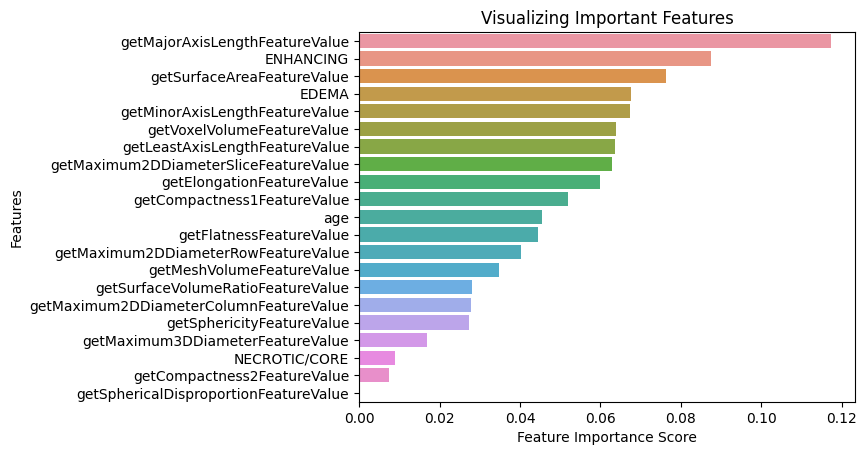

In [29]:
sns.barplot(x=feature_scores, y=feature_scores.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

### Confusion Matrix

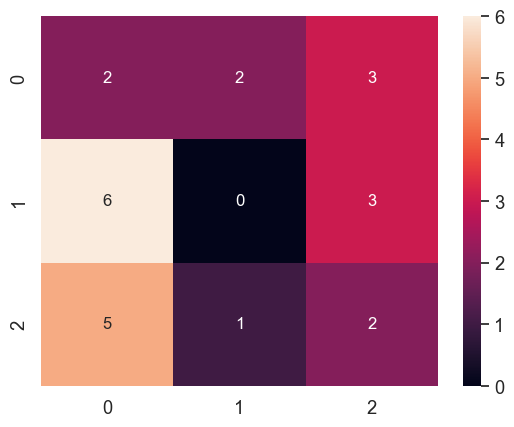

In [30]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

sns.set(font_scale=1.2) 
sns.heatmap(cm, annot=True, annot_kws={"size": 12}) 

plt.show()

In [31]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.00      0.00      0.00         9
           2       0.25      0.25      0.25         8

   micro avg       0.17      0.08      0.11        24
   macro avg       0.08      0.08      0.08        24
weighted avg       0.08      0.08      0.08        24
 samples avg       0.08      0.08      0.08        24



C:\Users\Larkana Computers\anaconda3\envs\BraTS\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Gridsearch
To find best score, I will try different value of:

1. n_estimators -> in range (1,100) with step 1
2. criterion parameters -> gini and entropy

In [32]:
grid = {
    'n_estimators':np.arange(1,100,1),
    'criterion':['gini','entropy']
    }

rfc_ = RandomForestClassifier(random_state = 42)
rf_grid = GridSearchCV(rfc_, grid, cv=5)
rf_grid.fit(X_train,y_train)

rf_grid_accuracy = rf_grid.score(X_test,y_test)
print("Hyperparameters:",rf_grid.best_params_)
print("Train Score:", rf_grid.best_score_*100)
print("Test Score:",rf_grid_accuracy*100)

Hyperparameters: {'criterion': 'entropy', 'n_estimators': 1}
Train Score: 33.50877192982456
Test Score: 45.83333333333333


# SVM Classifier

In [33]:
from sklearn.svm import SVC

#convert one hot into multilabel
y_train_multi=np.argmax(y_train, axis=1)
y_test_multi =np.argmax(y_test, axis=1)

svc = SVC(random_state = 42, C=10, degree=3, gamma=1, kernel='poly')
svc.fit(X_train,y_train_multi)
accuracies = cross_val_score(svc, X_train, y_train_multi)


y_pred = svc.predict(X_test)

print('Model accuracy score : {0:0.4f}'. format(accuracy_score(y_test_multi, y_pred)*100))

svm_accuracy = svc.score(X_test,y_test_multi)
print("Cross validation: Train Score:",np.mean(accuracies)*100)
print("Cross validation: Test Score:",svm_accuracy*100)

Model accuracy score : 37.5000
Cross validation: Train Score: 39.82456140350877
Cross validation: Test Score: 37.5


In [196]:
#y_pred_svm = svc.predict(X_test)

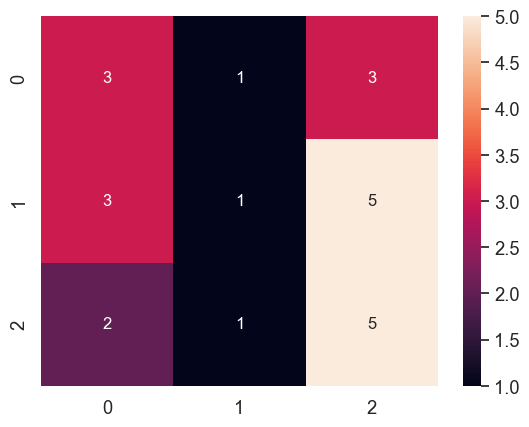

In [34]:
# convert to one hot
y_pred=y_pred.astype(int)
n_values = np.max(y_pred) + 1
y_pred_hot=np.eye(n_values)[y_pred]

cm = confusion_matrix(y_test.argmax(axis=1), y_pred_hot.argmax(axis=1))

sns.set(font_scale=1.2) 
sns.heatmap(cm, annot=True, annot_kws={"size": 12}) 

plt.show()

In [35]:
print(classification_report(y_test_multi, y_pred))

              precision    recall  f1-score   support

           0       0.38      0.43      0.40         7
           1       0.33      0.11      0.17         9
           2       0.38      0.62      0.48         8

    accuracy                           0.38        24
   macro avg       0.36      0.39      0.35        24
weighted avg       0.36      0.38      0.34        24



### GridSearch
To find best score, I will try different value of:

1. C -> Regularization parameter
2. kernel -> Specifies the kernel type to be used in the algorithm
3. degree -> Degree of the polynomial kernel function
4. gamma -> Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.

In [36]:
grid = {
    'C':[0.01,0.1,1,10,15,20],
    'kernel' : ["linear","poly","rbf","sigmoid"],
    'degree' : [1,3,5,7],
    'gamma' : [0.01,1]
}

svm  = SVC();
svm_grid = GridSearchCV(svm, grid, cv = 5)
svm_grid.fit(X_train,y_train_multi)
svm_grid_accuracy = svm_grid.score(X_test,y_test_multi) 

print("Best Parameters:",svm_grid.best_params_)
print("Train Score:",svm_grid.best_score_*100)
print("Test Score:",svm_grid_accuracy*100)

Best Parameters: {'C': 1, 'degree': 1, 'gamma': 0.01, 'kernel': 'linear'}
Train Score: 47.42690058479532
Test Score: 41.66666666666667


# KNN Classifier

In [37]:
from sklearn.neighbors import KNeighborsClassifier

knn  = KNeighborsClassifier(n_neighbors=38, p=2, weights='distance')
knn.fit(X_train,y_train_multi)
accuracies = cross_val_score(knn, X_train, y_train_multi)

y_pred = knn.predict(X_test)

print('Model accuracy score : {0:0.4f}'. format(accuracy_score(y_test_multi, y_pred)*100))

knn_accuracy = knn.score(X_test,y_test_multi)
print("Cross validation: Train Score:",np.mean(accuracies)*100)
print("Cross validation: Test Score:",knn_accuracy*100)

Model accuracy score : 29.1667
Cross validation: Train Score: 38.654970760233915
Cross validation: Test Score: 29.166666666666668


In [271]:
#y_pred_knn = knn.predict(X_test)

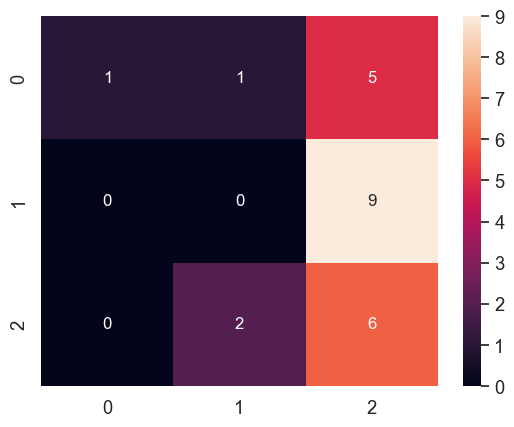

In [38]:
# convert to one hot
y_pred=y_pred.astype(int)
n_values = np.max(y_pred) + 1
y_pred_hot=np.eye(n_values)[y_pred]

cm = confusion_matrix(y_test.argmax(axis=1), y_pred_hot.argmax(axis=1))

sns.set(font_scale=1.2) 
sns.heatmap(cm, annot=True, annot_kws={"size": 12}) 

plt.show()

In [39]:
print(classification_report(y_test_multi, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.14      0.25         7
           1       0.00      0.00      0.00         9
           2       0.30      0.75      0.43         8

    accuracy                           0.29        24
   macro avg       0.43      0.30      0.23        24
weighted avg       0.39      0.29      0.22        24



### GridSearch
To find best score, I will try different value of:

1. n_neighbors -> Number of neighbors to use by default for kneighbors queries
2. p -> Power parameter for the Minkowski metric. When p = 1, this is equivalent to using manhattan_distance (l1), and euclidean_distance
3. weights -> weight function used in prediction

In [51]:
grid = {
    'n_neighbors':np.arange(1,75),
    'p':np.arange(1,5),
    'weights':['uniform','distance']
    }

knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn,grid,cv=5)
knn_grid.fit(X_train,y_train_multi)

print('Model accuracy score : {0:0.4f}'.format(accuracy_score(y_test_multi, y_pred)*100))

knn_grid_accuracy = knn_grid.score(X_test,y_test_multi)
print("Hyperparameters:",knn_grid.best_params_)
print("Train Score:",knn_grid.best_score_*100)
print("Test Score:",knn_grid_accuracy)

Model accuracy score : 29.1667
Hyperparameters: {'n_neighbors': 19, 'p': 1, 'weights': 'uniform'}
Train Score: 46.25730994152047
Test Score: 0.3333333333333333


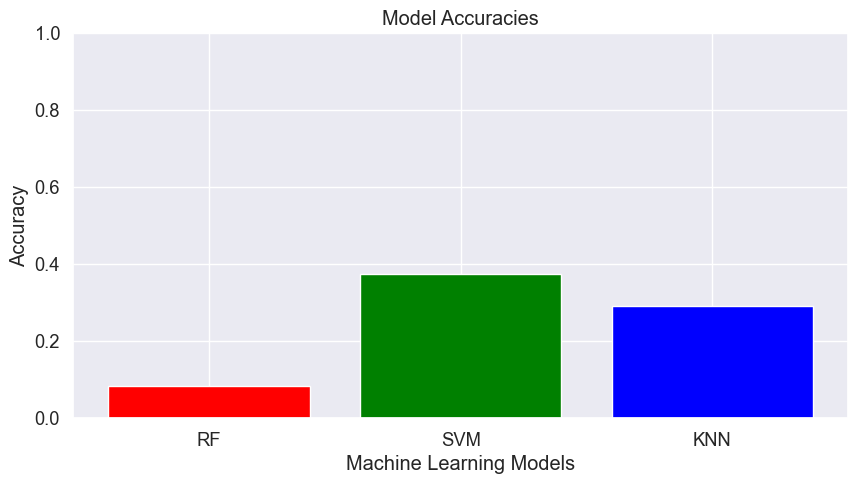

In [52]:
import matplotlib.pyplot as plt

# Demo data
model_names = ['RF', 'SVM', 'KNN']
accuracies = [rf_accuracy,  svm_accuracy,  knn_accuracy]  # Replace with actual accuracy values

# Set the figure size with figsize=(width, height)
plt.figure(figsize=(10, 5))

# Create bar graph
plt.bar(model_names, accuracies, color=['red', 'green', 'blue'])
plt.ylim(0, 1)  # Set y-axis limits between 0 and 1 for accuracy percentage
plt.title('Model Accuracies')
plt.xlabel('Machine Learning Models')
plt.ylabel('Accuracy')
plt.show()

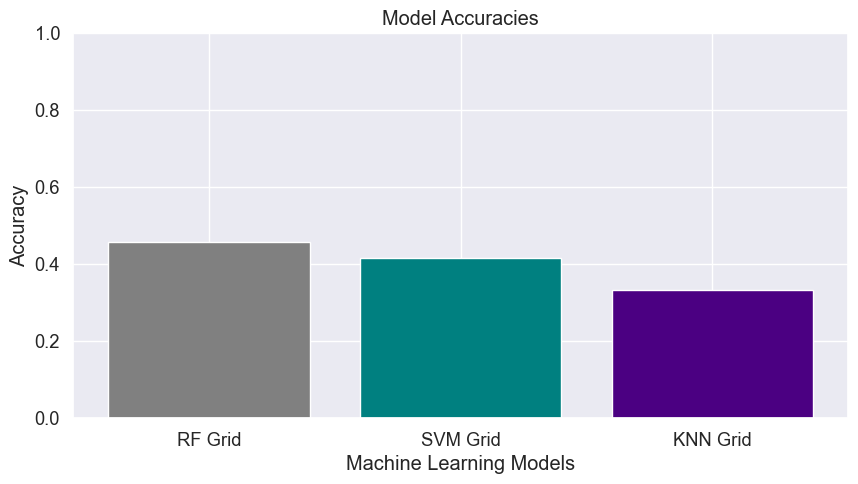

In [53]:
import matplotlib.pyplot as plt

# Demo data
model_names = ['RF Grid', 'SVM Grid', 'KNN Grid']
accuracies = [rf_grid_accuracy, svm_grid_accuracy, knn_grid_accuracy]  # Replace with actual accuracy values

# Set the figure size with figsize=(width, height)
plt.figure(figsize=(10, 5))

# Create bar graph
plt.bar(model_names, accuracies, color=['grey', 'teal', 'indigo'])
plt.ylim(0, 1)  # Set y-axis limits between 0 and 1 for accuracy percentage
plt.title('Model Accuracies')
plt.xlabel('Machine Learning Models')
plt.ylabel('Accuracy')
plt.show()

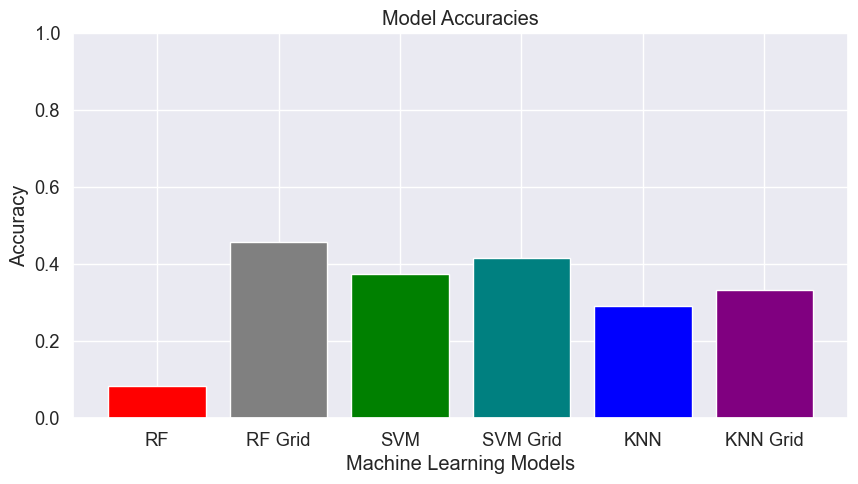

In [54]:
import matplotlib.pyplot as plt

# Demo data
model_names = ['RF', 'RF Grid', 'SVM', 'SVM Grid', 'KNN', 'KNN Grid']
accuracies = [rf_accuracy, rf_grid_accuracy, svm_accuracy, svm_grid_accuracy, knn_accuracy, knn_grid_accuracy]  # Replace with actual accuracy values

# Set the figure size with figsize=(width, height)
plt.figure(figsize=(10, 5))

# Create bar graph
plt.bar(model_names, accuracies, color=['red', 'grey', 'green', 'teal', 'blue', 'purple'])
plt.ylim(0, 1)  # Set y-axis limits between 0 and 1 for accuracy percentage
plt.title('Model Accuracies')
plt.xlabel('Machine Learning Models')
plt.ylabel('Accuracy')
plt.show()

# Ensemble Approach

## Bagging Ensemble

In [57]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np

# Initialize a Random Forest base classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Initialize the BaggingClassifier with the Random Forest base model
bagging_model = BaggingClassifier(base_estimator=rf, n_estimators=10, random_state=42)

# Train the bagging model
bagging_model.fit(X_train, y_train_multi)

# Make predictions using the bagging model
y_pred_bagging = bagging_model.predict(X_test)

# Evaluate the bagging model
accuracy_bagging = accuracy_score(y_test_multi, y_pred_bagging)
print('Bagging Accuracy: ', accuracy_bagging*100)

Bagging Accuracy:  50.0


# Voting / Aggrigating Ensemble

In [58]:
# Create a VotingClassifier to aggregate predictions
ensemble_model = VotingClassifier(estimators=[
    ('knn', knn),
    ('svm', svm),
    ('rf', rf)
], voting='hard')

# Train the ensemble model on the training data
ensemble_model.fit(X_train, y_train_multi)

# Make predictions using the ensemble model
y_pred_ensemble = ensemble_model.predict(X_test)

# Evaluate the ensemble model
voting_ensemble = accuracy_score(y_test_multi, y_pred_ensemble)

# Print the accuracy of the ensemble model
print(f'Ensemble Accuracy: ',voting_ensemble*100)

Ensemble Accuracy:  37.5


# Boosting Ensemble

In [59]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Assume you have your data in X and y

# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create base classifiers
base_knn = KNeighborsClassifier(n_neighbors=5)
base_svm = SVC(kernel='linear')
base_rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Create AdaBoost ensemble
adaboost_classifier = AdaBoostClassifier(
    base_estimator=None,  # If None, then the base estimator is a decision tree.
    n_estimators=50,       # Number of weak learners (default is 50)
    learning_rate=1.0      # Weight applied to each classifier (default is 1.0)
)

# Fit AdaBoost model
adaboost_classifier.fit(X_train, y_train_multi)

# Make predictions
adaboost_predictions = adaboost_classifier.predict(X_test)

# Evaluate accuracy
accuracy_adaboost = accuracy_score(y_test_multi, adaboost_predictions)
print("AdaBoost Accuracy:", accuracy_adaboost*100)

AdaBoost Accuracy: 33.33333333333333


# XGBoost Ensemble 

In [60]:
import xgboost as xgb

# Create base classifiers (you can use the same ones as before)
base_knn = KNeighborsClassifier(n_neighbors=5)
base_svm = SVC(kernel='linear')
base_rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Create XGBoost ensemble
xgboost_classifier = xgb.XGBClassifier(
    n_estimators=50,      # Number of boosting rounds
    learning_rate=0.1,    # Step size shrinkage to prevent overfitting
    max_depth=3           # Maximum depth of a tree
)

# Fit XGBoost model
xgboost_classifier.fit(X_train, y_train_multi)

# Make predictions
xgboost_predictions = xgboost_classifier.predict(X_test)

# Evaluate accuracy
accuracy_xgboost = accuracy_score(y_test_multi, xgboost_predictions)
print("XGBoost Accuracy:", accuracy_xgboost*100)


XGBoost Accuracy: 33.33333333333333


# Voting - Bagging - Adaboost Ensembles

In [61]:
# Initialize individual classifiers
#knn = KNeighborsClassifier(n_neighbors=5)
#svm = SVC(kernel='linear', C=1.0)
#rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Create a Decision Tree classifier for Bagging
base_classifier = DecisionTreeClassifier(max_depth=2)

# Create ensemble models using different techniques
voting_classifier = VotingClassifier(estimators=[
    ('knn', knn),
    ('svm', svm),
    ('rf', rf)
], voting='hard')

bagging_classifier = BaggingClassifier(base_estimator=base_classifier, n_estimators=10, random_state=42)

adaboost_classifier = AdaBoostClassifier(base_classifier, n_estimators=50, random_state=42)

# Train the ensemble models
voting_classifier.fit(X_train, y_train_multi)
bagging_classifier.fit(X_train, y_train_multi)
adaboost_classifier.fit(X_train, y_train_multi)

# Make predictions using the ensemble models
y_pred_voting = voting_classifier.predict(X_test)
y_pred_bagging = bagging_classifier.predict(X_test)
y_pred_adaboost = adaboost_classifier.predict(X_test)

# Evaluate the ensemble models
accuracy_voting = accuracy_score(y_test_multi, y_pred_voting)
accuracy_bagging = accuracy_score(y_test_multi, y_pred_bagging)
accuracy_adaboost = accuracy_score(y_test_multi, y_pred_adaboost)

# Print the accuracies of the ensemble models
print(f'Voting Classifier Accuracy: ', accuracy_voting*100)
print(f'Bagging Classifier Accuracy: ',accuracy_bagging*100)
print(f'AdaBoost Classifier Accuracy: ',accuracy_adaboost*100)

Voting Classifier Accuracy:  37.5
Bagging Classifier Accuracy:  29.166666666666668
AdaBoost Classifier Accuracy:  25.0


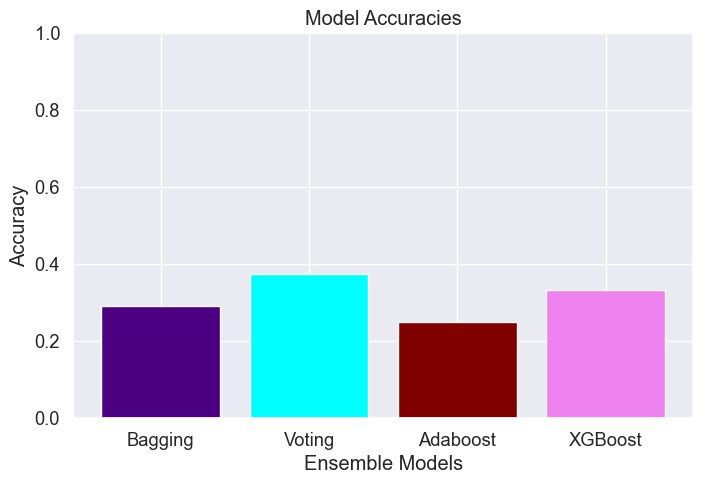

In [62]:
import matplotlib.pyplot as plt

#data
model_names = ['Bagging', 'Voting', 'Adaboost', 'XGBoost']
accuracies = [accuracy_bagging, accuracy_voting, accuracy_adaboost, accuracy_xgboost]  # Replace with actual accuracy values
plt.figure(figsize=(8, 5))

# Create bar graph
plt.bar(model_names, accuracies, color=['indigo', 'aqua', 'maroon', 'violet'])
plt.ylim(0, 1)  # Set y-axis limits between 0 and 1 for accuracy percentage
plt.title('Model Accuracies')
plt.xlabel('Ensemble Models')
plt.ylabel('Accuracy')
plt.show()

# Ensemble Approach on Separate Models

In [63]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np

# Assuming y_train and y_test are multi-output arrays
# Each column in y represents a separate output or label

# Create individual classifiers
classifier1 = RandomForestClassifier()
classifier2 = DecisionTreeClassifier()
classifier3 = SVC()

# Initialize an empty array for ensemble predictions
ensemble_preds = np.zeros_like(y_test)

# Initialize an array to store accuracy for each output
output_accuracies = np.zeros(y_test.shape[1])

# Train each classifier separately for each output
for i in range(y_train.shape[1]):
    classifier1.fit(X_train, y_train[:, i])
    classifier2.fit(X_train, y_train[:, i])
    classifier3.fit(X_train, y_train[:, i])

    # Make predictions for each output
    pred1 = classifier1.predict(X_test)
    pred2 = classifier2.predict(X_test)
    pred3 = classifier3.predict(X_test)

    # Combine predictions for each output
    ensemble_preds[:, i] = np.round((pred1 + pred2 + pred3) / 3)  # Adjust the combination method if needed

    # Evaluate accuracy for each output
    output_accuracies[i] = accuracy_score(y_test[:, i], ensemble_preds[:, i])

# Print accuracy for each output
for i, accuracy in enumerate(output_accuracies):
    print(f"Ensemble Accuracy for Output {i + 1}: ",round((accuracy*100),2))


Ensemble Accuracy for Output 1:  70.83
Ensemble Accuracy for Output 2:  62.5
Ensemble Accuracy for Output 3:  45.83


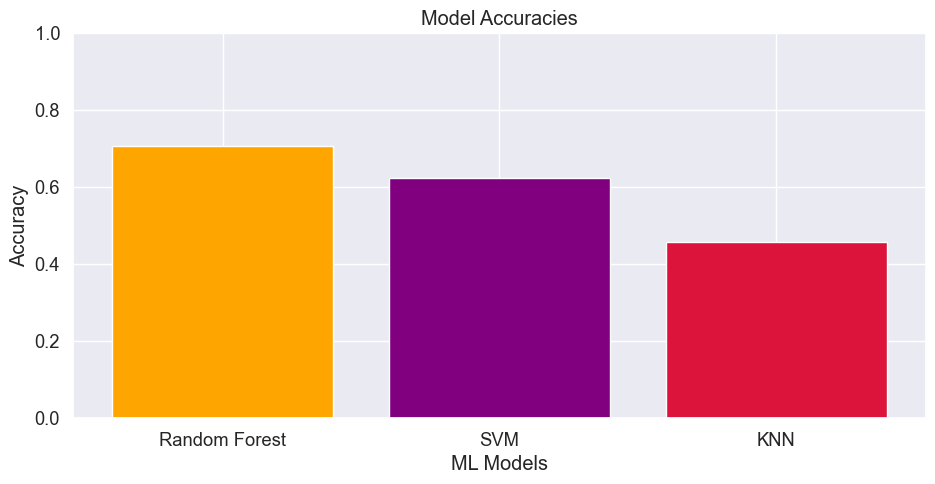

In [64]:
#All models
import matplotlib.pyplot as plt

# Demo data
model_names = ['Random Forest', 'SVM', 'KNN']
accuracies = [output_accuracies[0], output_accuracies[1], output_accuracies[2]]  # Replace with actual accuracy values

# Set the figure size with figsize=(width, height)
plt.figure(figsize=(11, 5))

# Create bar graph
plt.bar(model_names, accuracies, color=['orange', 'purple', 'crimson'])
plt.ylim(0, 1)  # Set y-axis limits between 0 and 1 for accuracy percentage
plt.title('Model Accuracies')
plt.xlabel('ML Models')
plt.ylabel('Accuracy')
plt.show()

In [67]:
#import radiomics
#print(radiomics.__version__)
#radiomics.__version__
#print(dir(radiomics))
#pip show radiomics
#help(radiomics)  or dir(radiomics) to list available attributes
#for submodule in radiomics.__path__:
#    print(submodule)
#radiomics.__path__
#import sys
#sys.version
#pip install python --version 3.8.18
#pip freeze